# Analysis presented in plots
Here we create the plots that allow us to do the analysis of the results. For each distribution that we present in the figures we calculate the KS two-samples statistics to have a numerical value on how different they really are (The value is the distance between the [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the samples).
We import all the packages necessary to plot the results from the models.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.lines as mlines
from matplotlib import cm

from scipy.stats import ks_2samp
from scipy.stats import binned_statistic

import astropy.units as u
from astropy.table import Table, join

Additionally, we add some shortcuts

In [3]:
# User shortcuts
def perc75(array):
    """75th Percentile"""
    return np.nanpercentile(array, 75)


def perc25(array):
    """25th Percentile"""
    return np.nanpercentile(array, 25)

## Join all clean results
We read the clean results from the models we are going to use

In [4]:
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits',
                    format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits',
                    format='fits')

ModelS37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK37.fits',
                      format='fits')
ModelF37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr37.fits',
                      format='fits')

We also read the original database of galaxies to use the information for the classification

In [5]:
Sample = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
# Renamed to use the join with the same id
Sample.rename_column('main_id', 'id')

We select a list of parameters from the models to be plotted (Check also the [11_Analysis_Tables](11_Analysis_Tables.ipynb) notebook to check why we choose these parameters). We add the estimated errors for these parameters in the lower panels. Also, we define some quantities useful to decorate the plots for each parameter.

In [6]:
param_check = ['bayes.agn.i', 'bayes.agn.fracAGN', 'bayes.agn.disk_luminosity', 'bayes.agn.EBV',
               'bayes.attenuation.E_BVs', 'bayes.sfh.tau_main', 'bayes.sfh.sfr']
ParamUnit = ['[degrees]', 'Fraction', r'log([L$_{\odot}$])', 'mag',
             'mag', r'log([Myr])', r'log([M$_{\odot}$/yr])']
ParamLabel = ['View. Angle', r'$f_{\rm{AGN}}$', r'$\rm{L}_{\rm{AGN}}^{\rm{disk}}$',
              r'Polar-dust E(B-V)', 'E(B-V)', r'$\tau_{\rm{main}}$', 'SFR']
ParamRange = [[0, 90], [0.05, 0.95], [7, 13], [0, 1],
              [0, 0.4], [1.5, 4], [-3, 3]]
param_check_err = [j+'_err' for j in param_check]
param_check_Rerr = [j+'_Relerr' for j in param_check]
ParamRangeErr = [[0, 40], [0.0, 0.4], [0, 1],
                 [0, 0.5], [0, 0.15], [0, 0.8], [0, 1]]
ParamUnitErr = ['[degrees]', 'Fraction', 'dex', 'mag', 'mag', 'dex', 'dex']
Particks = [[0, 25, 45, 65, 90], [0.25, 0.5, 0.75], [8, 10, 12], [0, 0.4, 0.8],
            [0, 0.2, 0.4], [2, 3, 4], [-2, 0, 2]]
ParticksErr = [[0, 10, 20, 30], [0, 0.1, 0.2, 0.3], [0.25, 0.5, 0.75], [0, 0.2, 0.4],
               [0, 0.05, 0.1], [0, 0.2, 0.4, 0.6], [0, 0.5, 1]]

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [7]:
SPandas = join(Sample, ModelS, keys='id').to_pandas()
FPandas = join(Sample, ModelF, keys='id').to_pandas()
SPandas37 = join(Sample, ModelS37, keys='id').to_pandas()
FPandas37 = join(Sample, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37],
                     keys=['SKIRTOR', 'Fritz', 'S37', 'F37'], names=['Model', 'idCIG'])

We estimate the relative errors from each parameter. Then, we transform luminosities from W to solar luminosities. Finally, we reformat some parameters in log units, useful for the plots. 

In [8]:
for kisd in param_check:
    SFPandas[kisd+'_Relerr'] = SFPandas[kisd+'_err']/SFPandas[kisd]
    
for kisd in ['bayes.agn.luminosity', 'bayes.agn.disk_luminosity', 'bayes.agn.accretion_power',
             'bayes.agn.dust_luminosity', 'bayes.dust.luminosity']:
    SFPandas[kisd] = (SFPandas[kisd].values*u.W).to(u.solLum).value
    SFPandas[kisd+'_err'] = (SFPandas[kisd+'_err'].values * u.W).to(u.solLum).value

for asdf in ['bayes.agn.disk_luminosity', 'bayes.agn.accretion_power',
             'bayes.sfh.sfr', 'bayes.sfh.tau_main']:
    SFPandas[asdf+'_err'] = SFPandas[asdf+'_err']/(SFPandas[asdf] * np.log(10))
    SFPandas[asdf] = np.log10(SFPandas[asdf])

Finally, we create two functions that will help us to plot all the comparisons in the same way and visualize the results from the KS statistics.

In [9]:
def param_fig(pand_tab, hue_mod, method='scott', order=None):
    """Figure used to present the results and comparisons for the selected parameters"""
    line_sty = ['-', '--', ':']
    for i_par, param in enumerate(param_check):
        plt.subplot2grid((3, len(param_check)), (0, i_par))
        if len(hue_mod) > 1:
            for k_par in range(len(hue_mod[1])):
                sns.kdeplot(data=pand_tab.loc[[hue_mod[1][k_par]]], x=param, hue=hue_mod[0],
                            legend=False, hue_order=order, clip=ParamRange[i_par], bw_method=method,
                            common_norm=False, ls=line_sty[k_par])
            if i_par > 0:
                plt.yticks([])
                plt.ylabel(None)
        else:
            sns.kdeplot(data=pand_tab, x=param, hue=hue_mod[0], legend=False, hue_order=order,
                        clip=ParamRange[i_par], bw_method=method, common_norm=False)
            if i_par > 0:
                plt.yticks([])
                plt.ylabel(None)
        plt.title(ParamLabel[i_par], fontsize=12)
        plt.xlabel(ParamUnit[i_par])
        plt.xlim(ParamRange[i_par])
        plt.xticks(Particks[i_par])
    for i_par, param in enumerate(param_check_err):
        plt.subplot2grid((3, len(param_check_err)), (1, i_par))
        if len(hue_mod) > 1:
            for k_par in range(len(hue_mod[1])):
                sns.kdeplot(data=pand_tab.loc[[hue_mod[1][k_par]]], x=param, hue=hue_mod[0],
                            legend=False, hue_order=order, clip=ParamRangeErr[i_par],
                            bw_method=method, common_norm=False, ls=line_sty[k_par])
            if i_par > 0:
                plt.yticks([])
                plt.ylabel(None)
        else:
            sns.kdeplot(data=pand_tab, x=param, hue=hue_mod[0], legend=False, hue_order=order,
                        clip=ParamRangeErr[i_par], bw_method=method, common_norm=False)
            if i_par > 0:
                plt.yticks([])
                plt.ylabel(None)
        plt.xlabel(ParamUnitErr[i_par])
        plt.xlim(ParamRangeErr[i_par])
        plt.xticks(ParticksErr[i_par])
    for i_par, param in enumerate(param_check_Rerr):
        plt.subplot2grid((3, len(param_check_Rerr)), (2, i_par))
        if len(hue_mod) > 1:
            for k_par in range(len(hue_mod[1])):
                sns.kdeplot(data=pand_tab.loc[[hue_mod[1][k_par]]], x=param, hue=hue_mod[0],
                            legend=False, hue_order=order, clip=(0.0, 2.0),
                            bw_method=method, common_norm=False, ls=line_sty[k_par])
                if param == 'bayes.agn.EBV_Relerr':
                    pandEVB = pand_tab[pand_tab['bayes.agn.EBV_Relerr'] < 3]
                    sns.kdeplot(data=pandEVB.loc[[hue_mod[1][k_par]]], x=param, hue=hue_mod[0],
                                legend=False, hue_order=order, clip=(0.0, 2.0),
                                bw_method=method, common_norm=False, ls=line_sty[k_par])
        else:
            sns.kdeplot(data=pand_tab, x=param, hue=hue_mod[0], legend=False, hue_order=order,
                        clip=(0.0, 2.0), bw_method=method, common_norm=False)
            if param == 'bayes.agn.EBV_Relerr':
                pandEVB = pand_tab[pand_tab['bayes.agn.EBV_Relerr'] < 3]
                sns.kdeplot(data=pandEVB, x=param, hue=hue_mod[0],
                            legend=False, hue_order=order, clip=(0.0, 2.0),
                            bw_method=method, common_norm=False)
        plt.xlabel('Frac. err.')
        plt.xlim(0, 1.5)
        plt.xticks([0, 0.5, 1])
        if i_par > 0:
            plt.yticks([])
            plt.ylabel(None)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                        right=0.9, hspace=0.4, wspace=0)


def critical_val(size1, size2, alpha=0.05):
    """Critical value for the KS two sample test"""
    section1 = -np.log(alpha/2)
    section2 = 1+(size2/size1)
    section3 = 2*size2
    return np.sqrt(section1*(section2/section3))


def matrix_ks(pand_tab, hue_mod, prob=0):
    """Create a matrix for the tae in pandas with the KS statistic and plot it."""
    _, ((ax1, ax2, ax3, ax4),
        (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
    axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    current_cmap = cm.get_cmap('RdBu')
    current_cmap.set_bad(color='gray')
    for i_par, param in enumerate(param_check):
        if len(hue_mod) == 1:
            matrix = np.empty((2, 16))*np.nan
            iterables = [hue_mod[0], hue_mod[0]]
            for i_tpar, tpar in enumerate(itertools.product(*iterables)):
                samp_1 = pand_tab.loc[[tpar[0]]][param]
                samp_2 = pand_tab.loc[[tpar[1]]][param]
                ks_test = ks_2samp(samp_1, samp_2)
                matrix[0, i_tpar] = ks_test[prob]
                if ks_test[0] <= critical_val(len(samp_1), len(samp_2)):
                    matrix[1, i_tpar] = 1
        if len(hue_mod) > 1:
            matrix = np.empty((2, len(hue_mod[1])**2))*np.nan
            iterables = [hue_mod[1], hue_mod[1]]
            for i_tpar, tpar in enumerate(itertools.product(*iterables)):
                t0_par = tpar[0].split(' ')
                t1_par = tpar[1].split(' ')
                samp_1 = pand_tab.loc[t0_par[0]][pand_tab.loc[t0_par[0]]
                                                 [hue_mod[0]] == t0_par[1]][param]
                samp_2 = pand_tab.loc[t1_par[0]][pand_tab.loc[t1_par[0]]
                                                 [hue_mod[0]] == t1_par[1]][param]
                ks_test = ks_2samp(samp_1, samp_2)
                matrix[0, i_tpar] = ks_test[prob]
                if ks_test[0] <= critical_val(len(samp_1), len(samp_2)):
                    matrix[1, i_tpar] = 1
        if prob == 1:
            matrix_v = (matrix[0]*matrix[1]
                        ).reshape(len(iterables[0]), len(iterables[0]))
            mat_s = axs[i_par].imshow(matrix_v, cmap='RdBu', vmin=0, vmax=1)
        else:
            matrix_v = (matrix[0]).reshape(
                len(iterables[0]), len(iterables[0]))
            mat_s = axs[i_par].imshow(matrix_v, cmap='RdBu')
        axs[i_par].set_title(param)
        axs[i_par].tick_params(axis='y', rotation=45)
        axs[i_par].tick_params(axis='x', rotation=45)
        plt.colorbar(mat_s, ax=axs[i_par], fraction=0.046, pad=0.04,
                     label=['KS statistic', 'Probability'][prob] if i_par == 6 else None)
    ax8.set_visible(False)
    plt.setp(axs, xticks=np.arange(len(iterables[0])), xticklabels=iterables[0],
             yticks=np.arange(len(iterables[0])), yticklabels=iterables[0])
    plt.subplots_adjust(wspace=0.6, hspace=0.05)

## Compare physical parameters between Fritz and SKIRTOR
##### FIGURE 6
We plot the density distribution of the parameters and the models used in this work, together with the density distributions of the errors derived by CIGALE.

In [10]:
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    plt.figure(figsize=(14.06, 4.77))
    param_fig(SFPandas, ['Model'])
    SKI = mlines.Line2D([], [], color='C0', label='SKIRTOR')
    Fri = mlines.Line2D([], [], color='C1', label='Fritz')
    S37 = mlines.Line2D([], [], color='C2', label='SK 30/70')
    F37 = mlines.Line2D([], [], color='C3', label='Fr 30/70')
    plt.legend(handles=[SKI, Fri, S37, F37], loc='upper right', fontsize=8)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                        right=0.9, hspace=0.6, wspace=0)
    plt.savefig('../Figures/F6.pdf', dpi=300, bbox_inches='tight')  # For Paper
#     plt.savefig('../Talk_Figures/F6.png',dpi=300,bbox_inches = 'tight') ## For Presentation

##### KS numerical values
We present the KS test graphically. The first panels are the KS statistic values. The second panel is the probability (p-value) only for cases where the KS statistic values is lower than the critical value at a $\alpha=0.05$ level.

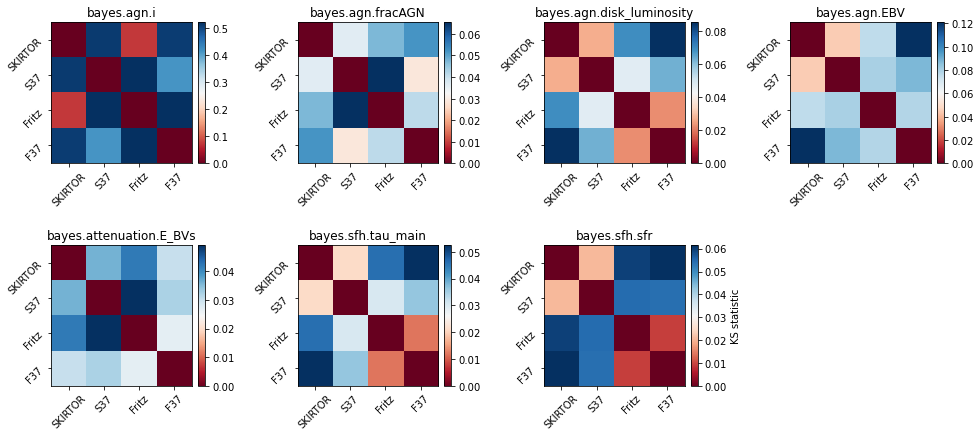

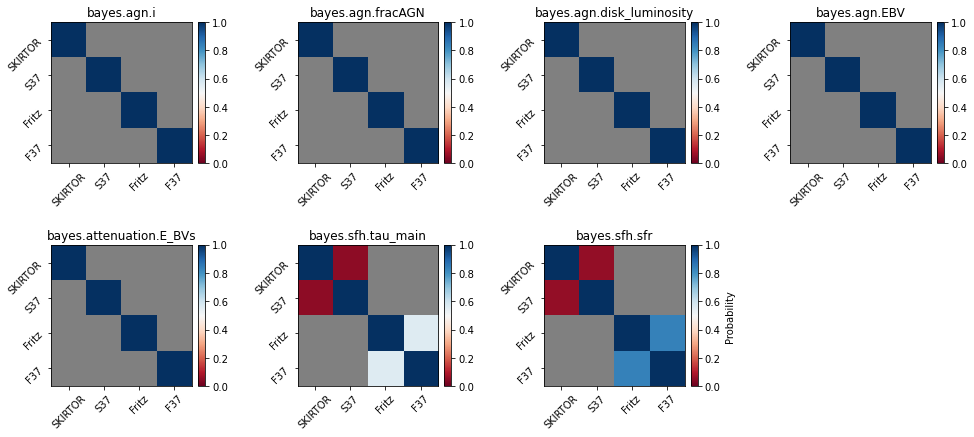

In [11]:
%matplotlib inline
matrix_ks(SFPandas, [['SKIRTOR', 'S37', 'Fritz', 'F37']], prob=0)
matrix_ks(SFPandas, [['SKIRTOR', 'S37', 'Fritz', 'F37']], prob=1)

## Compare physical parameters with Seyfert type
##### FIGURE 7
We plot the density distribution of the parameters but this time separating Seyfert type classification.

In [12]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    plt.figure(figsize=(14.06, 4.77))
    Selc5_1 = np.logical_or(np.logical_and(SFPandas['otype_txt'] == 'Sy1',
                                           SFPandas['Sp'] == 'S1'),
                            np.logical_and(SFPandas['otype_txt'] == 'Sy1',
                                           SFPandas['Sp'] == 'S1n'))
    Selc5_2 = np.logical_and(SFPandas['otype_txt'] == 'Sy2',
                             SFPandas['Sp'] == 'S2')
    Selc5 = np.logical_or(Selc5_1, Selc5_2)
    param_fig(SFPandas[Selc5], ['otype_txt', ['SKIRTOR', 'Fritz']])
    S1Cl = mlines.Line2D([], [], color='C0', label='Sy1 SK')
    S2Cl = mlines.Line2D([], [], color='C1', label='Sy2 SK')
    S1Sm = mlines.Line2D([], [], color='C0', label='Sy1 Fr', ls='--')
    S2Sm = mlines.Line2D([], [], color='C1', label='Sy2 Fr', ls='--')
    plt.legend(handles=[S1Cl, S2Cl, S1Sm, S2Sm], loc='upper right', fontsize=8)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                        right=0.9, hspace=0.6, wspace=0)
    plt.savefig('../Figures/F7.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../Talk_Figures/F7.png', dpi=300, bbox_inches='tight')  # For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test graphically. The first panels are the KS statistic values. The second panel is the probability (p-value) only for cases where the KS statistic values is lower than the critical value at a $\alpha=0.05$ level.

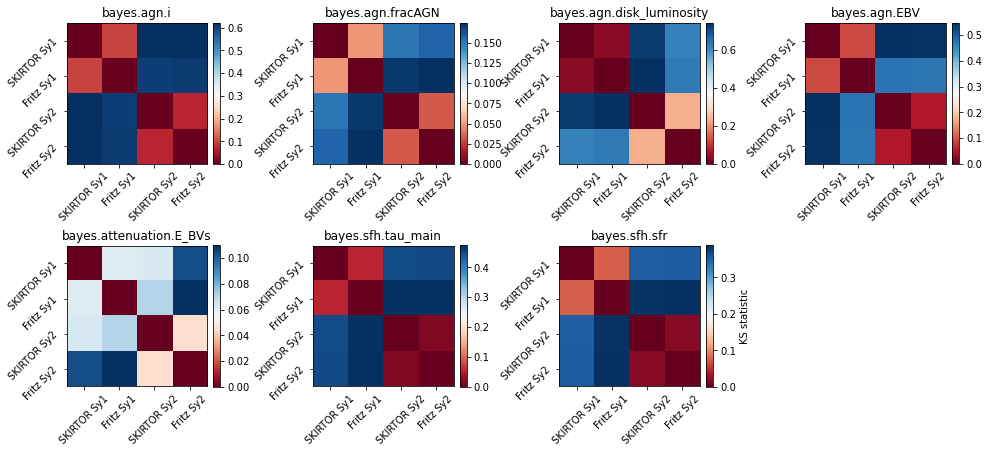

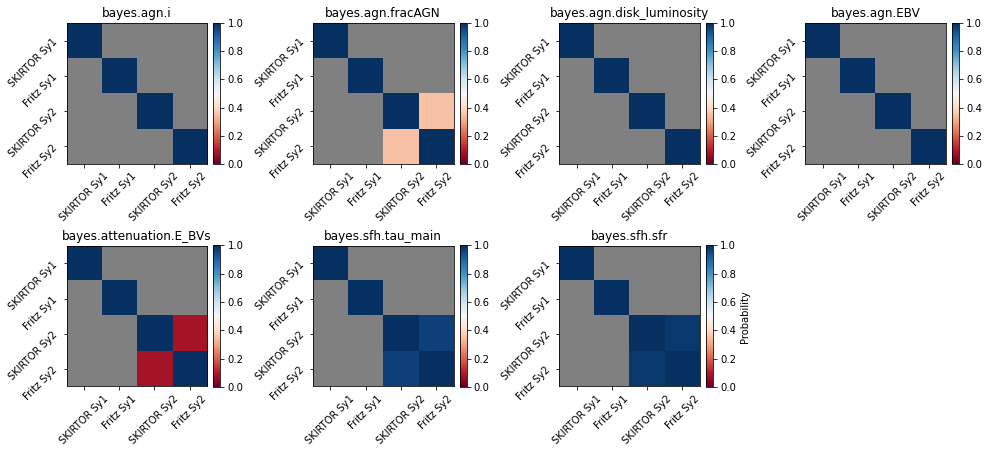

In [13]:
%matplotlib inline
matrix_ks(SFPandas[Selc5],
          ['otype_txt', ['SKIRTOR Sy1', 'Fritz Sy1', 'SKIRTOR Sy2', 'Fritz Sy2']], prob=0)
matrix_ks(SFPandas[Selc5],
          ['otype_txt', ['SKIRTOR Sy1', 'Fritz Sy1', 'SKIRTOR Sy2', 'Fritz Sy2']], prob=1)

We include an alternative version to this plot for the 30/70 cases

In [14]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    plt.figure(figsize=(14.06, 4.77))
    param_fig(SFPandas[Selc5], ['otype_txt', ['S37', 'F37']])
    S1Cla = mlines.Line2D([], [], color='C0', label='Sy1 SK 30/70')
    S2Cla = mlines.Line2D([], [], color='C1', label='Sy2 SK 30/70')
    S1Sma = mlines.Line2D([], [], color='C0', label='Sy1 Fr 30/70', ls='--')
    S2Sma = mlines.Line2D([], [], color='C1', label='Sy2 Fr 30/70', ls='--')
    plt.legend(handles=[S1Cla, S2Cla, S1Sma, S2Sma], loc='upper right', fontsize=8)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                        right=0.9, hspace=0.6, wspace=0)
    plt.savefig('../Figures/F7_Alt.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../Talk_Figures/F7_Alt.png', dpi=300, bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test graphically. The first panels are the KS statistic values. The second panel is the probability (p-value) only for cases where the KS statistic values is lower than the critical value at a $\alpha=0.05$ level.

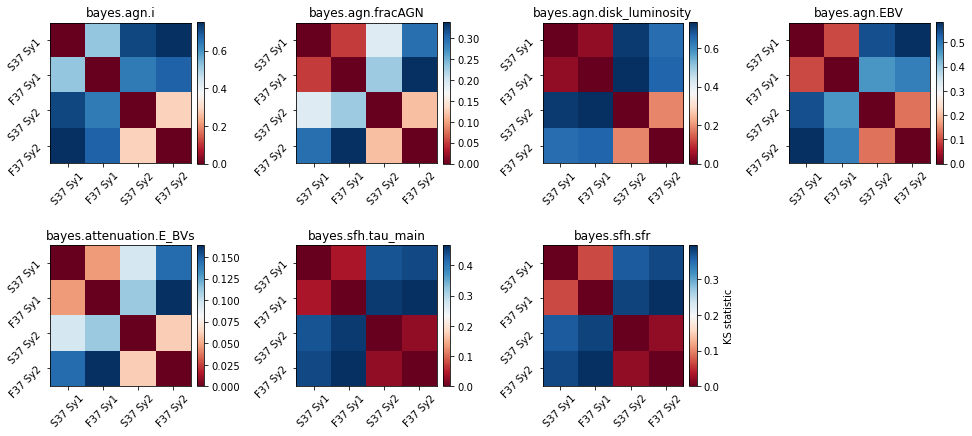

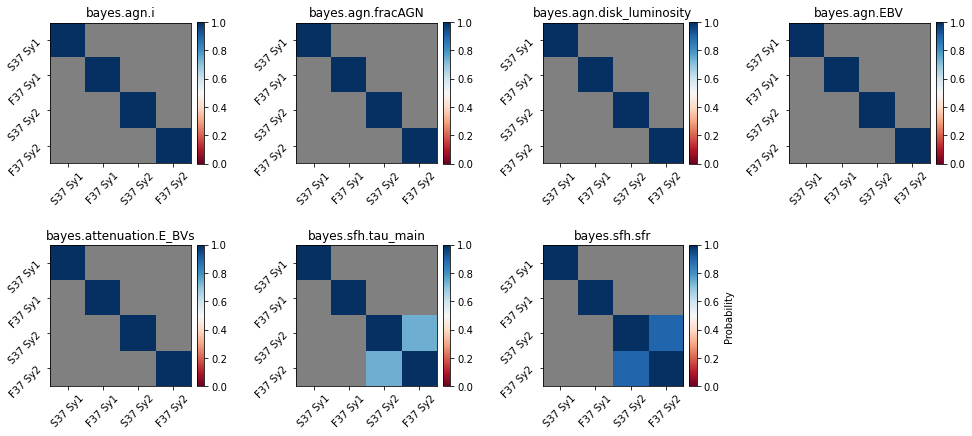

In [15]:
%matplotlib inline
matrix_ks(SFPandas[Selc5],
          ['otype_txt', ['S37 Sy1', 'F37 Sy1', 'S37 Sy2', 'F37 Sy2']], prob=0)
matrix_ks(SFPandas[Selc5],
          ['otype_txt', ['S37 Sy1', 'F37 Sy1', 'S37 Sy2', 'F37 Sy2']], prob=1)

## Compare VCV intermediate classifications
##### FIGURE 8
We plot the VCV-Osterbrock classification of Seyfert galaxies in the same way as before (Only with SKIRTOR results).

In [16]:
Selc7 = np.logical_or.reduce([SFPandas['Sp'] == 'S1.0', SFPandas['Sp'] == 'S1.2',
                              SFPandas['Sp'] == 'S1.5', SFPandas['Sp'] == 'S1.8',
                              SFPandas['Sp'] == 'S1.9'])

In [17]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    plt.figure(figsize=(14.06, 4.77))
    param_fig(SFPandas[Selc7], ['Sp', ['SKIRTOR']],
              order=['S1.0', 'S1.2', 'S1.5', 'S1.8', 'S1.9'])
    O1 = mlines.Line2D([], [], color='C0', label='Sy1.0')
    O2 = mlines.Line2D([], [], color='C1', label='Sy1.2')
    O3 = mlines.Line2D([], [], color='C2', label='Sy1.5')
    O4 = mlines.Line2D([], [], color='C3', label='Sy1.8')
    O5 = mlines.Line2D([], [], color='C4', label='Sy1.9')
    plt.legend(handles=[O1, O2, O3, O4, O5], loc='upper right', fontsize=8)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                        right=0.9, hspace=0.6, wspace=0)
    plt.savefig('../Figures/F8.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../Talk_Figures/F8.png', dpi=300, bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test graphically. The first panels are the KS statistic values. The second panel is the probability (p-value) only for cases where the KS statistic values is lower than the critical value at a $\alpha=0.05$ level.

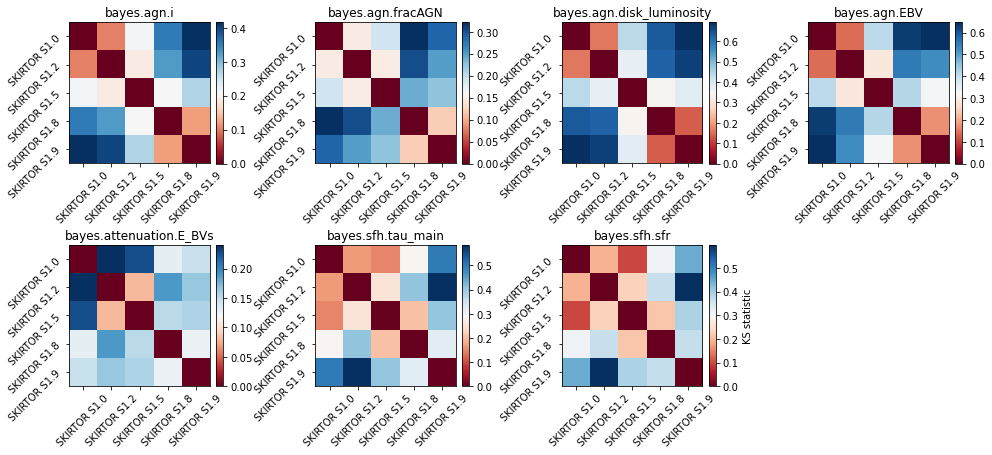

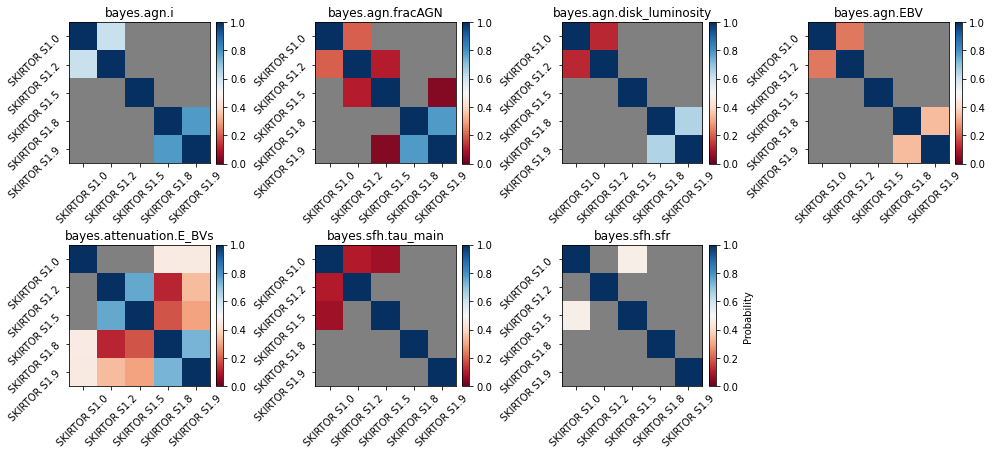

In [18]:
%matplotlib inline
matrix_ks(SFPandas[Selc7],
          ['Sp', ['SKIRTOR S1.0', 'SKIRTOR S1.2', 'SKIRTOR S1.5',
                  'SKIRTOR S1.8', 'SKIRTOR S1.9']], prob=0)
matrix_ks(SFPandas[Selc7],
          ['Sp', ['SKIRTOR S1.0', 'SKIRTOR S1.2', 'SKIRTOR S1.5',
                  'SKIRTOR S1.8', 'SKIRTOR S1.9']], prob=1)

## Redshift evolution of physical parameters
##### FIGURE 9
We now center on how the physical parameters in Seyferts change with redshift. We calculate the running/moving median for the parameters in terms of redshift. We only use the estimations coming from the SKIRTOR model in galaxies with z<=1 as only a few galaxies are above this limit.
The number of galaxies we are missing in the plots with this last restriction are:

In [10]:
sum(SPandas['rvz_redshift'] >= 1.01)

22

We define a class to plot an analyze the evolution of the parameters with redshift.

In [11]:
class RedshiftEvol:
    """Class to examine the redshift evolution of the parameters in CIGALE"""

    def __init__(self, Data, parameters, binsz, minpoints):
        self.data = Data
        self.param = parameters
        self.minpoint = minpoints
        self.binsz = binsz
        self.plot_redshift_ev()

    def print_dif(self, diff, paramet):
        """Function to print the minimun an  maximun difference between the Seyfert types with
        the location in terms of redshift."""
        min_dif = np.nanmin(diff)
        max_dif = np.nanmax(diff)
        loc_min = np.where(diff == min_dif)
        loc_max = np.where(diff == max_dif)
        print('For %s the minimum difference (%.2f) is at z=%.2f\n \
               \t while the maximum difference (%.2f) is at z=%.2f' % (paramet,
                                                                       min_dif,
                                                                       self.binsz[loc_min],
                                                                       max_dif,
                                                                       self.binsz[loc_max]))

    def linear_reg(self, binned_vals, mask):
        """Calculate the linear regresion with the intervals"""
        x_val = np.log10(1+self.binsz[:-1][mask])
        x_val = sm.add_constant(x_val)
        ols = sm.OLS(np.nanmean(binned_vals[:, :, mask],
                                axis=0)[0], x_val).fit()
        print(ols.summary())
        return ols.params

    def plot_redshift_ev(self):
        """Calculate the moving median for each parameter in terms of Seyfert 1 and Seyfert 2
        with a confidence interval between the 25th and 75th percentiles. For AGN disk
        luminosity and viewing angle we plot the criteria to separate the two samples."""
        _, axs = plt.subplots(len(self.param)+1, 1,
                              figsize=(6.75, 14.44), sharex=True)
        dict_lim_scat = {'Sy1': 0.8, 'Sy2': 0.625}
        for i_par, par_y in enumerate(self.param):
            compar_typ = np.zeros((2, 2, 40))
            for i_sy, sy_types in enumerate(['Sy1', 'Sy2']):
                subset = self.data['otype_txt'] == sy_types
                if i_par == 0:
                    axs[i_par].hist(self.data['rvz_redshift'][subset], histtype='step',
                                    bins=self.binsz, label=sy_types, lw=2)
                medians = [binned_statistic(self.data['rvz_redshift'][subset],
                                            self.data[par_y][subset],
                                            statistic=stat, bins=self.binsz)[0]
                           for stat in ['median', perc75, perc25]]
                good_sy = np.histogram(self.data['rvz_redshift'][subset],
                                       bins=self.binsz)[0] >= self.minpoint
                scat = np.logical_and(subset,
                                      self.data['rvz_redshift'] >= dict_lim_scat[sy_types])
                par_ax = axs[i_par+1].plot(self.binsz[:-1][good_sy], medians[0][good_sy],
                                           label=r'Param'+sy_types)
                axs[i_par+1].fill_between(self.binsz[:-1][good_sy], medians[1][good_sy],
                                          y2=medians[2][good_sy], alpha=0.2)
                axs[i_par+1].scatter(self.data['rvz_redshift'][subset][scat],
                                     self.data[par_y][subset][scat],
                                     c=par_ax[0].get_color(), alpha=0.2)
                if i_par == 3:
                    axs[i_par+1].set_ylabel('Polar-dust')
                else:
                    axs[i_par+1].set_ylabel(ParamLabel[i_par])
                compar_typ[i_sy, 0, :] = medians[0]
                compar_typ[i_sy, 1, :] = medians[1]-medians[2]
            dif_array = np.ptp(compar_typ[:, 0, :], axis=0)[good_sy]
            if par_y == 'bayes.agn.i':
                axs[i_par+1].plot(self.binsz[:-1],
                                  np.ones(len(self.binsz[:-1]))*45,
                                  ls='--')
            if par_y == 'bayes.agn.disk_luminosity':
                vals_reg = self.linear_reg(compar_typ, good_sy)
                X = np.log10(1+self.binsz[:-1])
                y = np.nanmean(compar_typ, axis=0)[0]
                axs[i_par+1].plot(self.binsz[:-1][good_sy],
                                  vals_reg[0] + vals_reg[1] *
                                  np.log10(1+self.binsz[:-1][good_sy]),
                                  ls='--', c='C2')
                condition_lim = self.binsz[:-1] >= dict_lim_scat['Sy2']
                axs[i_par+1].plot(self.binsz[:-1][condition_lim],
                                  (vals_reg[0] + vals_reg[1]*np.log10(1 +
                                   np.ones(len(self.binsz[:-1][condition_lim]))*0.6)),
                                  ls=':', C='C2')
            self.print_dif(dif_array, ParamLabel[i_par])
            axs[i_par+1].set_xlim(-0.01, 1.01)
            axs[i_par+1].set_ylim(ParamRange[i_par])
            if i_par == 4:
                axs[i_par+1].set_yticks([0.1, 0.2, 0.3])
            else:
                axs[i_par+1].set_yticks(Particks[i_par])
        axs[0].set_ylabel('# Gal.')
        axs[0].set_xlim(-0.01, 1.01)
        axs[0].legend(loc='best')
        axs[0].set_yticks([150, 300, 450])
        axs[-1].set_xlabel(r'$\rm{Redshift}$')
        plt.subplots_adjust(wspace=0, hspace=0)

Finally, we plot the results. We limited the number a galaxies in a bin to a minimum of 6 galaxies. After that we plot the galaxies as scatter plots.

In [13]:
# %matplotlib
# Values of redshifts to bin the data
RzBins = np.linspace(0.0, 1.0, 41)  # or 21,31
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    RedshiftEvol(SFPandas.loc['SKIRTOR'], param_check, RzBins, 6)
    plt.savefig('../Figures/F9.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../Talk_Figures/F9.png',dpi=300,bbox_inches = 'tight') ## For Presentation

For View. Angle the minimum difference (23.42) is at z=0.03
                	 while the maximum difference (63.22) is at z=0.43
For $f_{\rm{AGN}}$ the minimum difference (0.00) is at z=0.30
                	 while the maximum difference (0.20) is at z=0.62
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     203.4
Date:                 wo, 04 aug 2021   Prob (F-statistic):           3.24e-13
Time:                        15:02:09   Log-Likelihood:                 6.6326
No. Observations:                  26   AIC:                            -9.265
Df Residuals:                      24   BIC:                            -6.749
Df Model:                           1                                         
Covariance Type:            nonr

Finally we check how much representative is the contribution of the disk AGN luminosity to the total AGN luminosity

In [22]:
def contrib_disk_lum(data):
    """Calculate the contribution of the disk and dut AGN luminosity for the Seyfert types"""
    for sy_types in ['Sy1', 'Sy2']:
        subset = data[data['otype_txt'] == sy_types]
        contrib = (10**subset['bayes.agn.disk_luminosity'] /
                   subset['bayes.agn.luminosity'])
        print(('For %s the median contribution of AGN dust luminosity is %.2f\n '
               '\t with a minimum of %.3f and a maximum of %.3f') % (sy_types,
                                                                     np.median(contrib),
                                                                     np.min(contrib),
                                                                     np.max(contrib)))
        contrib = (subset['bayes.agn.dust_luminosity'] /
                   subset['bayes.agn.luminosity'])
        print(('For %s the median contribution of AGN dust luminosity is %.2f\n '
               '\t with a minimum of %.3f and a maximum of %.3f') % (sy_types,
                                                                     np.median(contrib),
                                                                     np.min(contrib),
                                                                     np.max(contrib)))

In [23]:
contrib_disk_lum(SFPandas.loc['SKIRTOR'])

For Sy1 the median contribution of AGN dust luminosity is 0.52
 	 with a minimum of 0.001 and a maximum of 0.815
For Sy1 the median contribution of AGN dust luminosity is 0.48
 	 with a minimum of 0.185 and a maximum of 0.999
For Sy2 the median contribution of AGN dust luminosity is 0.04
 	 with a minimum of 0.001 and a maximum of 0.795
For Sy2 the median contribution of AGN dust luminosity is 0.96
 	 with a minimum of 0.205 and a maximum of 0.999


## Intrinsic luminosity
Here we plot the intrinsic luminosity for all the combination of plots shown before.

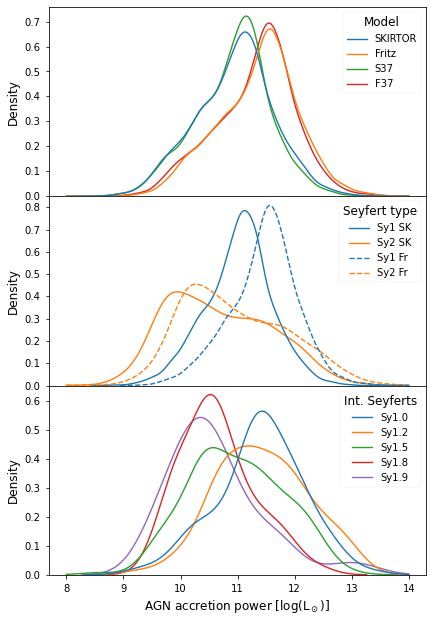

In [24]:
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                                        figsize=(6.75, 10.44),
                                        sharex=True)
    sns.kdeplot(data=SFPandas, x='bayes.agn.accretion_power', hue='Model', clip=[8, 14],
                common_norm=False, ax=ax1)
    line_sty = ['-', '--']
    for i_par, k_par in enumerate(['SKIRTOR', 'Fritz']):
        sns.kdeplot(data=SFPandas[Selc5].loc[k_par],
                    x='bayes.agn.accretion_power', hue='otype_txt', clip=[8, 14],
                    common_norm=False, ls=line_sty[i_par], ax=ax2, label=k_par)
    ax2.legend(handles=[S1Cl, S2Cl, S1Sm, S2Sm],
               loc='upper right', fontsize=10, title='Seyfert type')
    sns.kdeplot(data=SFPandas[Selc7].loc[['SKIRTOR']],
                x='bayes.agn.accretion_power', hue='Sp', clip=[8, 14], common_norm=False,
                hue_order=['S1.0', 'S1.2', 'S1.5', 'S1.8', 'S1.9'], ax=ax3)
    plt.legend(handles=[O1, O2, O3, O4, O5],
               loc='upper right', fontsize=10, title='Int. Seyferts')
    plt.xlabel(r'AGN accretion power [$\log(\rm{L}_\odot)$]')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('../Figures/F10.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../Talk_Figures/F10.png',dpi=300,bbox_inches = 'tight') ## For Presentation

##### Notebook info

In [25]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
autopep8  : 1.5.7
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
pandas    : 1.2.0
seaborn   : 0.11.1
numpy     : 1.19.5
matplotlib: 3.2.2
astropy   : 4.2
re        : 2.2.1
json      : 2.0.9
logging   : 0.5.1.2

Watermark: 2.1.0

